In [4]:
import pandas as pd
from pathlib import Path
import pathlib
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from pathlib import Path
from shapely.geometry import Polygon
import pdb
import  cv2
import PIL

In [4]:
OPENSLIDE_PATH=Path('openslide-win64-20230414')

OPENSLIDE_FOLDER=os.path.join(Path().resolve(),'openslide-win64-20230414','openslide-win64-20230414','bin')

In [5]:
if hasattr(os,'add_dll_directory'):
    with os.add_dll_directory(OPENSLIDE_FOLDER):
        import openslide
else:
    import openslide
    
    

In [1]:

from dataloading.src.annotation_parser import AnnotationParser


In [2]:
from dataloading.src.wsi_datasets_tst import WSI_Pyramid

In [3]:
import pdb
root=Path('WSI_download/WSI_data')

#label_path=root/'labels'
label_path=root/'labels'
image_path=root/'images'

parser=AnnotationParser(image_path,label_path)
anno_df,image_f,errored=parser.parse_annotations()

NameError: name 'Path' is not defined

In [2]:
#%%writefile  dataloading/src/wsi_datasets_tst.py
from __future__ import annotations
from torch.utils.data import Dataset,DataLoader
from shapely.geometry import Polygon,MultiPolygon
import  cv2
import numpy as np
import pandas as pd
from functools import partial
import torch
from pathlib import Path
import os
import pathlib


    


class WSI_Pyramid(Dataset):


    """Pytorch Dataset class representing a multiscale WSI dataset.inputs are img and anno dfs containing info 
         about WSI images and annotations.Pyramidal crops are sampled from the pyramid_top_levels (usually set to the most
         zoomed in level in the tiff dataset although more than one level can be used) ,with a downsample factor of one . A crop is 
         chosen from the top level of size crop_sz X crop_sz and concentric crops of the same size are chosen in the next
         num_pyramid_level levels."""
   
    
    def __init__(self,
                 anno_df:pd.DataFrame,
                 crop_pixel_size:tuple=(256,256),
                 transform=None,
                 ## default set to show all levels, mostly {0:1} top level is picked
                 pyramid_top_level={0:1.0},
                 num_pyramid_levels=4, 
                 num_pyramid_mask_levels=1,
                 filter_flag=False)->None:
       
        
       
        self.anno_df=anno_df
        ## the size in pixel of  each crop -size is kept same at 
        ## various zoom levels for batching
        self.crop_pixel_size=crop_pixel_size
        self.item_transform = transform
        self.class2num={'Tumor':1}
        ## create on self.device
        ## offsets to add to crop center to get vertices
        self.offsets=torch.tensor(self.crop_pixel_size)//2
        ## get the downsample levels common in the entire dataset
        self.common_downsample_levels=min(self.anno_df['downsample_levels'],key=len)
        ## take the intersect of user provided ds levels and the ones present in the data
        self.pyramid_top_level=pyramid_top_level
        self.pyramid_all_levels=max(self.anno_df['downsample_levels'],key=len)

        
        self.pyramid_top_idx=list(self.pyramid_top_level.keys())[0]
        self.pyramid_top_downsample=list(self.pyramid_top_level.values())[0]
        
        self.num_pyramid_levels=num_pyramid_levels
        self.num_pyramid_mask_levels=num_pyramid_mask_levels
        assert self.num_pyramid_levels>= self.num_pyramid_mask_levels,'num_pyramid_levels used for inputs should be more than num of target maska'
        
        ## the actual levels of the tiff pyramid used as input to the model
        self.pyramid_zoom_levels={idx:self.common_downsample_levels[idx] for idx in range(self.pyramid_top_idx,self.num_pyramid_levels)}
        
        self.filter_flag=filter_flag
        
    def __len__(self):
        return len(self.anno_df)
    
    
    def get_pyramid_crops(self,annotation_row:pd.Series):
        
        """ get a random center crop at any possible zoom level from the periphery
           of an annotation """
       

       
       
        wsi_size,anno_coordinates=(np.array(x) for x in [annotation_row['WSI_size'],
                                                             annotation_row['coordinates']])

        random_crop_index=np.random.randint(0,len(anno_coordinates))
        random_crop_center=torch.tensor(anno_coordinates[random_crop_index])
        # pdb.set_trace()
        offsets_arr=torch.tensor([[-1,1],[1,1],[1,-1],[-1,-1]])*self.offsets   # 4 X 2
        downsample_arr=torch.tensor(list(self.pyramid_zoom_levels.values())).unsqueeze(1).unsqueeze(1)

       
        pyramid_crops=offsets_arr.unsqueeze(0)*downsample_arr+random_crop_center.unsqueeze(0).unsqueeze(0)# Pyramid_Levels X 4 X 2  (one crop for each level)
        pyramid_crops=np.array(pyramid_crops).astype(np.int32)

        pyramid_top_lefts=pyramid_crops.min(axis=1)   # Pyramid_Levels X 2
      

        ## get the top left of every sampled level in the pyramidal tiff by subtracting offset from crop center and scaling by downsample factor
        #sampled_top_lefts={idx:random_crop_center-self.offsets*d_factor for idx,d_factor in self.pyramid_zoom_levels.items()}

        return pyramid_crops,pyramid_top_lefts


    def filter_crops_byWSIsize(self,wsi_size:tuple,all_crops:np.ndarray):
        
         
    
        max_bounds=np.max(all_crops,axis=1).values<wsi_size.unsqueeze(0)
        min_bounds=np.min(all_crops,axis=1).values>torch.zeros_like(wsi_size.unsqueeze(0))
        
        ## get all feasible crops/tiles which are wholly within the WSI bounds, associated with that particular annotation
        all_crops=all_crops[np.logical_and(max_bounds.all(axis=1),min_bounds.all(axis=1))]

        ## if there is no possible crop that fits in the WSI image for a particular annotation and zoom level, retrn 
        ## empty tensors
        
         
        return all_crops
    
   
        
        
        
        
   
    def get_mask_per_class(self,class_annotation_data:pd.DataFrame,crop:np.ndarray,
                          downsample_factor:float)->torch.tensor:
       
        """"function to create masks of each class given the annotation data and crop(image) 
            coordinates=(4X2 shape) also the donsample factor of the crop to scale the polygon coords"""
        annotation_class=class_annotation_data['class_name'].iloc[0]
        annotation_num=self.class2num[annotation_class]
        
        
        ## select the top left point of the crop
        ## its the point with the min X and Y corrdinates (top left of image is origin)
        
        top_left=crop.min(axis=0)
        
        ## create a shapely polygon from crop to find intersections between annotations and crop
        
        crop_poly=Polygon(crop)
        
        ## create list of intersecting polygons with crop to fill with clss encoding
        
        intersects=[]
        for poly in  class_annotation_data['polygon']:
            if not crop_poly.intersects(poly):
                continue
            else:
                intersect=crop_poly.intersection(poly)
                
                if isinstance(intersect,MultiPolygon):
                    for inter in intersect.geoms:
                        ext_coords=((np.array(inter.convex_hull.exterior.coords)-top_left)//downsample_factor).astype(np.int32)
                        intersects.append(ext_coords)
                elif isinstance(intersect,Polygon):
                        ext_coords=((np.array(intersect.convex_hull.exterior.coords)-top_left)//downsample_factor).astype(np.int32)
                        intersects.append(ext_coords)
                else:
                        continue
                        
                        
                

                    
        mask=np.zeros(self.crop_pixel_size,dtype=np.uint8)
        
       
        ## fill the intersected polygons within the mask
        cv2.fillPoly(mask,intersects,color=annotation_num)
        
        return torch.tensor(mask,dtype=torch.uint8)
        
        
        
    def read_slide_region(self,slide_obj:openslide.OpenSlide,top_left:np.ndarray,
                         level:int):
        """ returns the pixel RGB from WSI given a location,crop_size and level"""
        #pdb.set_trace()
        return slide_obj.read_region(tuple(top_left.astype(np.int32)),level,self.crop_pixel_size)

    def get_dl(self,batch_size,shuffle=True):
        return DataLoader(dataset=self,batch_size=batch_size,shuffle=True)

    def get_img_T(self,pyramid_top_lefts:np.ndarray,image_path:pathlib.Path):

        img_T=np.concatenate([np.array(self.read_slide_region(openslide.OpenSlide(image_path),sampled_top_left,zoom_level))[:,:,:-1] 
                  for zoom_level,sampled_top_left in zip(self.pyramid_zoom_levels,pyramid_top_lefts)],axis=2)
        img_T=torch.tensor(img_T).permute(2,0,1)
        return img_T
        
        


    def get_msk_T(self,pyramid_crops:np.ndarray,image_anno_data:pd.DataFrame):
        pyramid_msk=[]
        for i in range(self.num_pyramid_mask_levels):
            get_classwise_masks=partial(self.get_mask_per_class,
                                              crop=pyramid_crops[i],
                                              downsample_factor= list(self.pyramid_zoom_levels.values())[i])
            
            class_wise_masks=image_anno_data.groupby('class_name').apply(get_classwise_masks)
    
    
    
    
            ## stack the masks of various classes
            stacked_masks=torch.stack(class_wise_masks.to_list(),dim=0)
            
            ## create a composite mask with higher class numbers taking precedence in case of ties
            
            composite_mask=stacked_masks.max(dim=0)
            pyramid_msk.append(composite_mask.values)
        
        return torch.stack(pyramid_msk)



    
    def __getitem__(self, index):
        ## select annotation 
        anno_row=self.anno_df.iloc[index]
        
        ## select all annotations in the same image as indexed annotation
        image_name,anno_class=anno_row['image_name'],anno_row['class_name']
        dowsample_levels=anno_row['downsample_levels']
        image_path=anno_row['image_path']
        image_anno_data=self.anno_df[self.anno_df['image_name']==image_name]
        
        ## select pyramidal crops from N_levels zoom levels
        pyramid_crops,pyramid_top_lefts=self.get_pyramid_crops(anno_row)

        ## create a stack of pyramid crops centered at the annotation with as many zoom levels as descibed by pyramid_levels
        img_T=self.get_img_T(pyramid_top_lefts,image_path)
        mask_T=self.get_msk_T(pyramid_crops,image_anno_data)
    
        return img_T,mask_T



Overwriting dataloading/src/wsi_datasets_tst.py


In [166]:
pyr=WSI_Pyramid(anno_df,num_pyramid_levels=4,num_pyramid_mask_levels=4)

In [167]:
dl=pyr.get_dl(batch_size=8)

In [178]:
x,y=next(iter(dl))

In [179]:
img_b=x.reshape(8*4,3,256,256)
mask_b=y.reshape(8*4,1,256,256)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


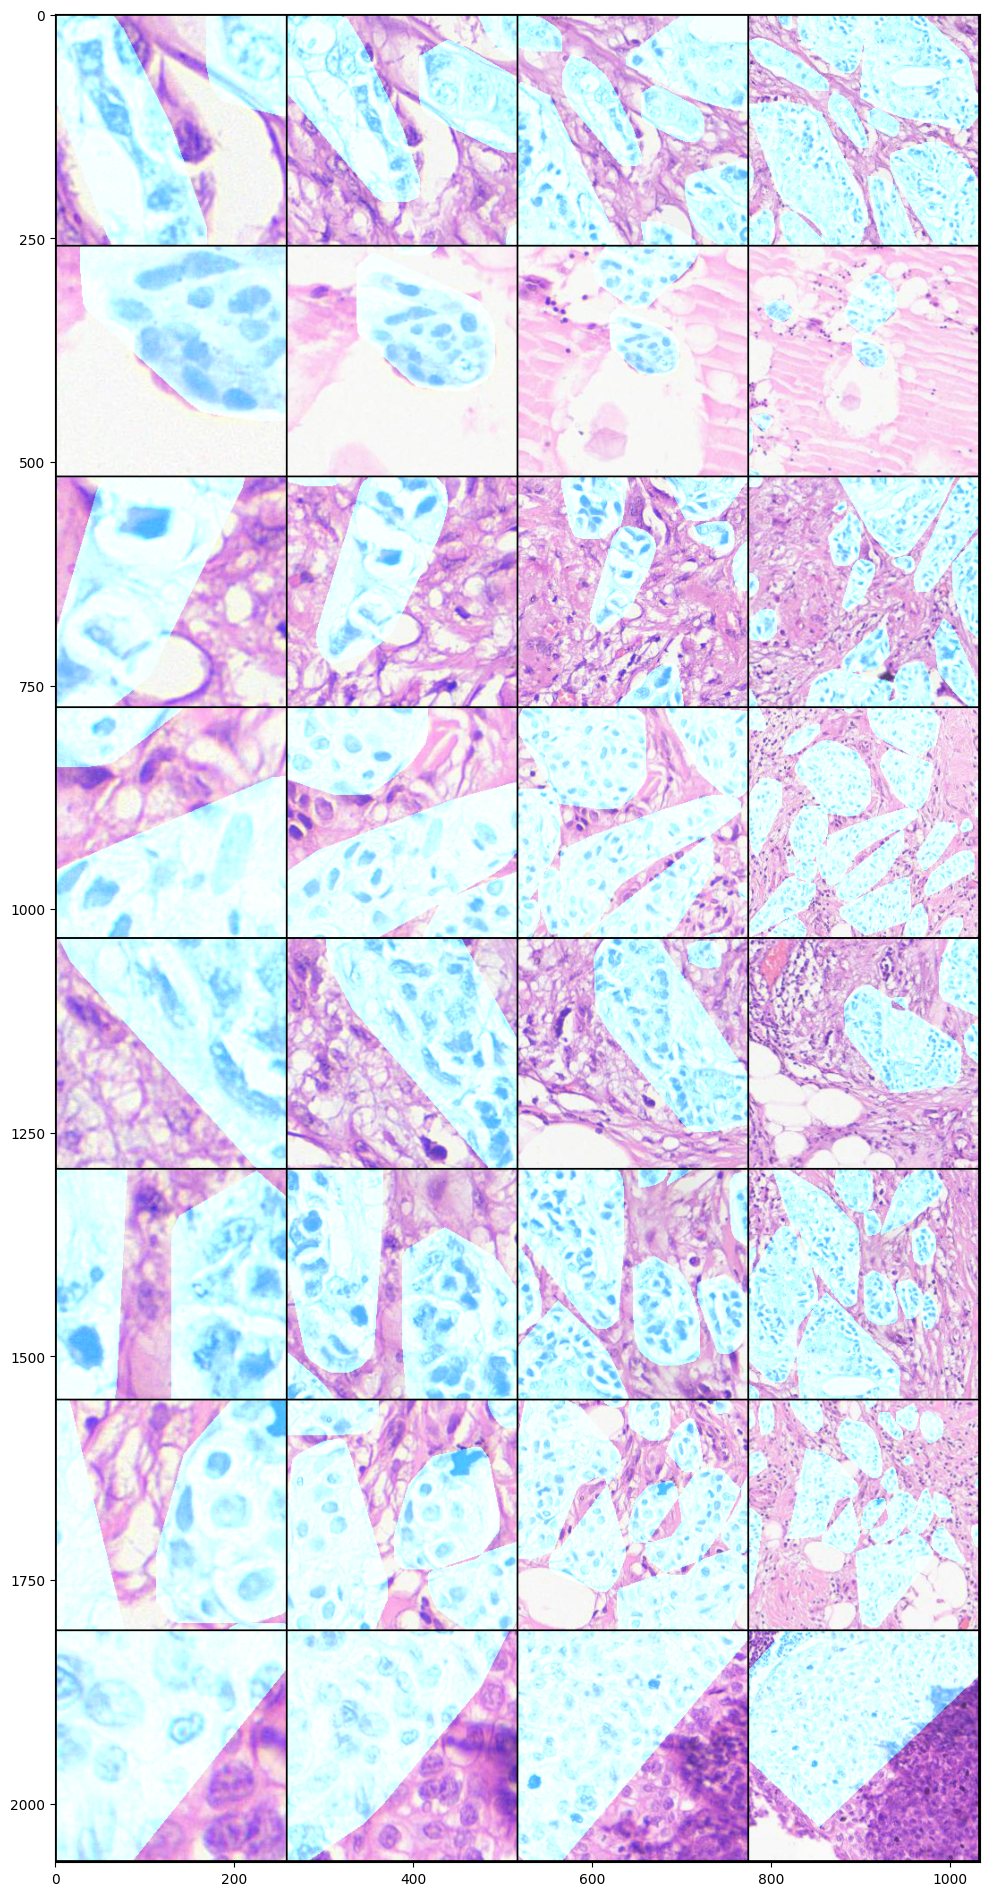

In [182]:
fig = plt.figure(figsize=(32, 24))
color_b=mask_b*torch.tensor((0,128,255)).unsqueeze(0).unsqueeze(2).unsqueeze(3)
overlay_b=img_b+color_b
grid_img=make_grid(overlay_b,nrow=4)
plt.imshow(grid_img.permute(1,2,0))

In [255]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

# Define your PyTorch Lightning module (inherits from pl.LightningModule)
class SegLightningModule(pl.LightningModule):
    def __init__(self, segmentation_model):
        super(SegLightningModule, self).__init__()
        # Define your model architecture here
        self.segmentation_model=segmentation_model

    def forward(self, x):
        # Define the forward pass of your model
        
        return self.segmentation_model(x)
    
    def flattened_cross_entropy_loss(self,inp,tgt):
        
        tgt=tgt.flatten(start_dim=-2)
        inp=inp.flatten(start_dim=-2)
      
        return nn.functional.cross_entropy(inp, tgt)
    
    
    def training_step(self, batch, batch_idx):
        # Define the training step
      
        img_b,mask_b=batch
        img_b=img_b.to(torch.float32)
        #taking the mask at the highest zoom  as target
        mask_b=mask_b[:,0,:,:].to(torch.int64) 
        
        y_pred = self(img_b)
        
        loss = self.flattened_cross_entropy_loss(y_pred, mask_b)
        self.log('train_loss', loss,on_step=False,on_epoch=True,prog_bar=True)  # Log the training loss for TensorBoard
        return loss

    def validation_step(self, batch, batch_idx):
        # Define the training step
      
        img_b,mask_b=batch
        img_b=img_b.to(torch.float32)
        #taking the mask at the highest zoom  as target
        mask_b=mask_b[:,0,:,:].to(torch.int64) 
        
        y_pred = self(img_b)
        loss = self.flattened_cross_entropy_loss(y_pred, mask_b)
        self.log('val_loss', loss,on_step=False,on_epoch=True,prog_bar=True)  # Log the training loss for TensorBoard
        return loss
        


    def configure_optimizers(self):
        # Define your optimizer
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [37]:
trainer = pl.Trainer(max_epochs=10, accelerator='gpu')
trainer.fit(model=seg_model, train_dataloaders=dl_train,val_dataloaders=dl_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
A:\mini\envs\aipath\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
A:\mini\envs\aipath\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:68: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

Epoch 9: 100%|████████████████████████████████████████████████████████████████| 57/57 [00:22<00:00,  2.52it/s, v_num=8]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████| 57/57 [00:26<00:00,  2.14it/s, v_num=8]


In [256]:
from sklearn.model_selection import train_test_split


class experiment_runner():
    
    
    def __init__(self,model,root=Path('WSI_download/WSI_data')
                 
                 
               ):
            
            label_path=root/'labels'
            image_path=root/'images'
            self.parser=AnnotationParser(image_path,label_path)
            self.anno_df,self.image_df,self.errored=self.parser.parse_annotations()
            
            
            
            self.pl_module=SegLightningModule(model)
            
            
    
    
    
    def get_dls(self,
               batch_size=8,
                num_pyramid_levels=4,
                num_pyramid_mask_levels=1,
                crop_pixel_size=(256,256),
                pyramid_top_level={0: 1.0}
                
                ):

            #filtering out image_name with less than 2 annotations for stratifying using train_test_split
            vc=self.anno_df['image_name'].value_counts()
            filt_df=self.anno_df.merge(vc.reset_index())
            filt_df=filt_df[filt_df['count']>2]
            #filt_df=filt_df[filt_df['count']==max(vc)]
        
            df_train,df_val=train_test_split(filt_df,test_size=0.2,random_state=42,stratify=filt_df['image_name'])
            ds_train,ds_val=(WSI_Pyramid(anno_df=df, 
                                         pyramid_top_level=pyramid_top_level,
                                         num_pyramid_levels=num_pyramid_levels,
                                         num_pyramid_mask_levels=num_pyramid_mask_levels) for df in (df_train,df_val))
            
           
            dl_train,dl_val=(dset.get_dl(batch_size=batch_size) for dset in (ds_train,ds_val))
            
        
            return dl_train,dl_val


    
    
    def show_batch(self,kind='train',
                   mask_color=torch.tensor((0,128,255)),
                   num_pyramid_levels=4,
                   crop_pixel_size=(256,256),
                   pyramid_top_level={0: 1.0},
                    batch_size=8
                   
                    ):

          dl_train,dl_val=self.get_dls(batch_size=batch_size,
                                                   num_pyramid_levels=num_pyramid_levels,
                                                   num_pyramid_mask_levels=num_pyramid_levels,
                                                   crop_pixel_size=crop_pixel_size,
                                                   pyramid_top_level=pyramid_top_level
                                                   )



            
            
          if kind=='train':
            
            img_b,mask_b=next(iter(dl_train))
            #pdb.set_trace()

          if kind=='val':
            
             img_b,mask_b=next(iter(dl_val))

        
          H,W=crop_pixel_size
          img_b=img_b.reshape(batch_size*num_pyramid_levels,3,H,W)

          #pdb.set_trace()
          mask_b=mask_b.reshape(batch_size*num_pyramid_levels,1,H,W)

        
          fig = plt.figure(figsize=(32,24))
          color_b=mask_b*mask_color.unsqueeze(0).unsqueeze(2).unsqueeze(3)
          overlay_b=img_b+color_b
          grid_img=make_grid(overlay_b,nrow=num_pyramid_levels)
          plt.imshow(grid_img.permute(1,2,0))

         

    
    def run_training(self,epochs,
                     num_pyramid_levels=4,
                     num_pyramid_mask_levels=1,
                     crop_pixel_size=(256,256),
                     pyramid_top_level={0: 1.0},
                     batch_size=8):

        dl_train,dl_val=self.get_dls(batch_size=batch_size,
                                     num_pyramid_levels=num_pyramid_levels,
                                     num_pyramid_mask_levels=num_pyramid_mask_levels,
                                     crop_pixel_size=crop_pixel_size,
                                     pyramid_top_level=pyramid_top_level)
                                                   

        
        
        
        
        trainer = pl.Trainer(max_epochs=epochs, accelerator='gpu')
        trainer.fit(model=self.pl_module, train_dataloaders=dl_train,val_dataloaders=dl_val)
            

            
            

<function torchvision.utils.make_grid(tensor: Union[torch.Tensor, List[torch.Tensor]], nrow: int = 8, padding: int = 2, normalize: bool = False, value_range: Optional[Tuple[int, int]] = None, scale_each: bool = False, pad_value: float = 0.0, **kwargs) -> torch.Tensor>

In [243]:
import segmentation_models_pytorch as smp

unet = smp.UnetPlusPlus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=12,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

In [245]:
train,val=xpt.get_dls()

In [257]:
xpt=experiment_runner(model=unet)
#xpt.update_dls(downsample_levels={0:1.0})

In [260]:
xpt.run_training(epochs=20)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type         | Params
----------------------------------------------------
0 | segmentation_model | UnetPlusPlus | 26.1 M
----------------------------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.428   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

A:\mini\envs\aipath\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
A:\mini\envs\aipath\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


A:\mini\envs\aipath\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|███████████████████████████████████████████████████████████████| 57/57 [00:49<00:00,  1.15it/s, v_num=20]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|█████████████████████████████| 57/57 [00:42<00:00,  1.33it/s, v_num=20, val_loss=2.910, train_loss=0.618]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|█████████████████████████████| 57/57 [00:38<00:00,  1.49it/s, v_num=20, val_loss=0.682, train_loss=0.591]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|█████████████████████████████| 57/57 [00:39<00:00,  1.44it/s, v_num=20, val_loss=0.750, train_loss=0.570]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████████████████████████| 57/57 [00:38<00:00,  1.48it/s, v_num=20, val_loss=0.814, train_loss=0.562]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|█████████████████████████████| 57/57 [00:37<00:00,  1.52it/s, v_num=20, val_loss=0.633, train_loss=0.548]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|█████████████████████████████| 57/57 [00:38<00:00,  1.48it/s, v_num=20, val_loss

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|████████████████████████████| 57/57 [00:53<00:00,  1.06it/s, v_num=20, val_loss=1.060, train_loss=0.533]
